# CM4107 Advanced Artificial Intelligence
## Coursework Part 1 - ANN
## Alistair Quinn 1701183

### Imports

In [94]:
%matplotlib inline
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import pandas as pd
import random
import operator

### Load Train and Test Datasets 

In [95]:
datasets = {'wine':{},'breast_cancer':{}}
#Dataset 1: Wine
file = open('datasets/wine/wine_train.csv','r')
file.readline()
datasets['wine']['train'] = file.readlines()
file.close()
file = open('datasets/wine/wine_test.csv','r')
file.readline()
datasets['wine']['test'] = file.readlines()
file.close()
#Dataset 2: Breast Cancer
file = open('datasets/breast_cancer/breast_cancer_train.csv','r')
file.readline()
datasets['breast_cancer']['train'] = file.readlines()
file.close()
file = open('datasets/breast_cancer/breast_cancer_train.csv', 'r')
file.readline()
datasets['breast_cancer']['test'] = file.readlines()
file.close()

### Set Variables

#### Wine Dataset

In [96]:
datasets['wine']['inputnodes'] = 11
datasets['wine']['hiddennodes'] = 10
datasets['wine']['outputnodes'] = 11

#### Breast Cancer Database 

In [97]:
#ANN
datasets['breast_cancer']['inputnodes'] = 30
datasets['breast_cancer']['hiddennodes'] = 15
datasets['breast_cancer']['outputnodes'] = 2

### ANN Class
#### From Lab 3

In [98]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs for training the network towards achieving convergence
    batch_size : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 0 standard gradient descent
      batch_size > 0 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.1, batch_size=1, epochs=10):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',') 
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(self.onodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch

    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs):
        self.results = []
        
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            self.results.append([predict_label, target_label])
            #compute network error
            ##if (predict_label == target_label):
              ##  self.results.append(1)
            ##else: 
             ##   self.results.append(0)
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays

### Util Functions 

In [99]:
#Func to Train and Test ANNs based on list of single hyper-parameter 
def annHyperParamTest(test_values_array, train_data, test_data,inputnodes,hiddennodes,outputnodes,hyper_param_name):
    #Train
    anns = train(test_values_array, train_data, inputnodes,hiddennodes,outputnodes, hyper_param_name)
    #Test
    results = test(anns, test_data)
    #Graph Results
    graph(test_values_array, results, hyper_param_name)
    #Return results
    return results

#trains a set of models for each param value passed 
def train(test_values_array, train_data, inputnodes,hiddennodes,outputnodes,hyper_param_name):
    anns = []
    for item in test_values_array:
        ann = neuralNetwork(**({'inputnodes':inputnodes,'hiddennodes':hiddennodes,'outputnodes':outputnodes,hyper_param_name:item}))
        ann.train(train_data)
        anns.append(ann)
    return anns

def test(anns,test_data):
    results = []
    for ann in anns:
        correct = 0
        ann.test(test_data)
        for result in ann.results:
            if (result[0] == result[1]):
                correct += 1
            pass 
        correct = 100 * (correct/len(ann.results))
        results.append(correct)
        pass
    return results
    
def graph(test_values_array, results, hyper_param_name):
    y_pos = np.arange(len(test_values_array))
    plt.bar(y_pos,results,align="center",alpha=0.5)
    plt.xticks(y_pos,test_values_array)
    plt.ylabel('Accuracy')
    plt.title(hyper_param_name)
    plt.show()

### Evaluation of Varying Hyper-Parameters 

#### Test Values

#### Epoch

In [100]:
#Test Values
hidden_nodes = [2,4,6,8,10,12,14,16,18,20]

##### Test Values

##### Wine Dataset 

In [101]:
#Test Values
epoch_test_values = [50,100,150,200,250]

##### Wine Dataset

Training epoch#:  0
errors (SSE):  [1729.11668323]
Training epoch#:  1
errors (SSE):  [1611.69202691]
Training epoch#:  2
errors (SSE):  [1608.99985537]
Training epoch#:  3
errors (SSE):  [1608.10466599]
Training epoch#:  4
errors (SSE):  [1607.6821862]
Training epoch#:  5
errors (SSE):  [1607.44615804]
Training epoch#:  6
errors (SSE):  [1607.29970819]
Training epoch#:  7
errors (SSE):  [1607.20158975]
Training epoch#:  8
errors (SSE):  [1607.13158841]
Training epoch#:  9
errors (SSE):  [1607.07880024]
Training epoch#:  10
errors (SSE):  [1607.03691233]
Training epoch#:  11
errors (SSE):  [1607.00206177]
Training epoch#:  12
errors (SSE):  [1606.97177503]
Training epoch#:  13
errors (SSE):  [1606.94440522]
Training epoch#:  14
errors (SSE):  [1606.91881675]
Training epoch#:  15
errors (SSE):  [1606.89420034]
Training epoch#:  16
errors (SSE):  [1606.86996021]
Training epoch#:  17
errors (SSE):  [1606.8456431]
Training epoch#:  18
errors (SSE):  [1606.82089211]
Training epoch#:  19
err

errors (SSE):  [1607.08958294]
Training epoch#:  11
errors (SSE):  [1607.05811375]
Training epoch#:  12
errors (SSE):  [1607.03139316]
Training epoch#:  13
errors (SSE):  [1607.00779302]
Training epoch#:  14
errors (SSE):  [1606.98619754]
Training epoch#:  15
errors (SSE):  [1606.96581842]
Training epoch#:  16
errors (SSE):  [1606.9460822]
Training epoch#:  17
errors (SSE):  [1606.92655923]
Training epoch#:  18
errors (SSE):  [1606.90691776]
Training epoch#:  19
errors (SSE):  [1606.88689325]
Training epoch#:  20
errors (SSE):  [1606.86626764]
Training epoch#:  21
errors (SSE):  [1606.84485486]
Training epoch#:  22
errors (SSE):  [1606.82249058]
Training epoch#:  23
errors (SSE):  [1606.7990248]
Training epoch#:  24
errors (SSE):  [1606.77431637]
Training epoch#:  25
errors (SSE):  [1606.74822891]
Training epoch#:  26
errors (SSE):  [1606.72062756]
Training epoch#:  27
errors (SSE):  [1606.69137655]
Training epoch#:  28
errors (SSE):  [1606.66033711]
Training epoch#:  29
errors (SSE): 

errors (SSE):  [1606.86576884]
Training epoch#:  20
errors (SSE):  [1606.8406382]
Training epoch#:  21
errors (SSE):  [1606.81469857]
Training epoch#:  22
errors (SSE):  [1606.78776224]
Training epoch#:  23
errors (SSE):  [1606.75965583]
Training epoch#:  24
errors (SSE):  [1606.7302147]
Training epoch#:  25
errors (SSE):  [1606.6992787]
Training epoch#:  26
errors (SSE):  [1606.66668888]
Training epoch#:  27
errors (SSE):  [1606.63228492]
Training epoch#:  28
errors (SSE):  [1606.59590291]
Training epoch#:  29
errors (SSE):  [1606.55737364]
Training epoch#:  30
errors (SSE):  [1606.51652096]
Training epoch#:  31
errors (SSE):  [1606.47316046]
Training epoch#:  32
errors (SSE):  [1606.42709812]
Training epoch#:  33
errors (SSE):  [1606.37812915]
Training epoch#:  34
errors (SSE):  [1606.32603682]
Training epoch#:  35
errors (SSE):  [1606.27059131]
Training epoch#:  36
errors (SSE):  [1606.21154859]
Training epoch#:  37
errors (SSE):  [1606.14864929]
Training epoch#:  38
errors (SSE):  

errors (SSE):  [1476.80394658]
Training epoch#:  178
errors (SSE):  [1476.40285344]
Training epoch#:  179
errors (SSE):  [1476.00842996]
Training epoch#:  180
errors (SSE):  [1475.62053576]
Training epoch#:  181
errors (SSE):  [1475.23903834]
Training epoch#:  182
errors (SSE):  [1474.86381242]
Training epoch#:  183
errors (SSE):  [1474.49473934]
Training epoch#:  184
errors (SSE):  [1474.1317064]
Training epoch#:  185
errors (SSE):  [1473.77460638]
Training epoch#:  186
errors (SSE):  [1473.42333698]
Training epoch#:  187
errors (SSE):  [1473.07780039]
Training epoch#:  188
errors (SSE):  [1472.73790283]
Training epoch#:  189
errors (SSE):  [1472.40355416]
Training epoch#:  190
errors (SSE):  [1472.07466751]
Training epoch#:  191
errors (SSE):  [1471.75115892]
Training epoch#:  192
errors (SSE):  [1471.43294707]
Training epoch#:  193
errors (SSE):  [1471.11995295]
Training epoch#:  194
errors (SSE):  [1470.81209965]
Training epoch#:  195
errors (SSE):  [1470.50931206]
Training epoch#:

errors (SSE):  [1493.39748426]
Training epoch#:  136
errors (SSE):  [1492.6052615]
Training epoch#:  137
errors (SSE):  [1491.83502373]
Training epoch#:  138
errors (SSE):  [1491.08577705]
Training epoch#:  139
errors (SSE):  [1490.35656658]
Training epoch#:  140
errors (SSE):  [1489.64647738]
Training epoch#:  141
errors (SSE):  [1488.95463498]
Training epoch#:  142
errors (SSE):  [1488.28020551]
Training epoch#:  143
errors (SSE):  [1487.62239551]
Training epoch#:  144
errors (SSE):  [1486.98045146]
Training epoch#:  145
errors (SSE):  [1486.35365907]
Training epoch#:  146
errors (SSE):  [1485.74134238]
Training epoch#:  147
errors (SSE):  [1485.14286269]
Training epoch#:  148
errors (SSE):  [1484.55761735]
Training epoch#:  149
errors (SSE):  [1483.9850385]
Training epoch#:  150
errors (SSE):  [1483.42459165]
Training epoch#:  151
errors (SSE):  [1482.87577429]
Training epoch#:  152
errors (SSE):  [1482.33811441]
Training epoch#:  153
errors (SSE):  [1481.81116903]
Training epoch#: 

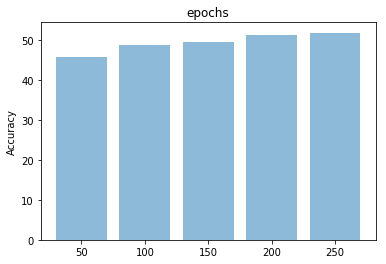

In [102]:
#Test Epochs
wine_epoch_results = annHyperParamTest(epoch_test_values, 
                         datasets['wine']['train'], 
                         datasets['wine']['test'],
                         datasets['wine']['inputnodes'],
                         datasets['wine']['hiddennodes'],
                         datasets['wine']['outputnodes'],
                         'epochs')

In [103]:
wine_epoch_results

[45.73295222539812,
 48.75459371171907,
 49.407921600653324,
 51.204573295222545,
 51.857901184156795]

Epochs of 250 gave greatest accuracy, graph trend shows accuracy increase with as number of epochs increases 

##### Breast_Cancer_Dataset 

Training epoch#:  0
errors (SSE):  [130.26806859]
Training epoch#:  1
errors (SSE):  [128.71639388]
Training epoch#:  2
errors (SSE):  [128.51430311]
Training epoch#:  3
errors (SSE):  [128.314578]
Training epoch#:  4
errors (SSE):  [128.11462907]
Training epoch#:  5
errors (SSE):  [127.91393864]
Training epoch#:  6
errors (SSE):  [127.71200077]
Training epoch#:  7
errors (SSE):  [127.50831324]
Training epoch#:  8
errors (SSE):  [127.30237653]
Training epoch#:  9
errors (SSE):  [127.09369291]
Training epoch#:  10
errors (SSE):  [126.8817655]
Training epoch#:  11
errors (SSE):  [126.66609757]
Training epoch#:  12
errors (SSE):  [126.44619173]
Training epoch#:  13
errors (SSE):  [126.22154938]
Training epoch#:  14
errors (SSE):  [125.99167008]
Training epoch#:  15
errors (SSE):  [125.75605113]
Training epoch#:  16
errors (SSE):  [125.51418716]
Training epoch#:  17
errors (SSE):  [125.26556981]
Training epoch#:  18
errors (SSE):  [125.0096876]
Training epoch#:  19
errors (SSE):  [124.7460

errors (SSE):  [125.62684824]
Training epoch#:  15
errors (SSE):  [125.37161886]
Training epoch#:  16
errors (SSE):  [125.1097071]
Training epoch#:  17
errors (SSE):  [124.84060553]
Training epoch#:  18
errors (SSE):  [124.56380708]
Training epoch#:  19
errors (SSE):  [124.27880528]
Training epoch#:  20
errors (SSE):  [123.98509462]
Training epoch#:  21
errors (SSE):  [123.68217095]
Training epoch#:  22
errors (SSE):  [123.36953216]
Training epoch#:  23
errors (SSE):  [123.04667885]
Training epoch#:  24
errors (SSE):  [122.71311522]
Training epoch#:  25
errors (SSE):  [122.36835005]
Training epoch#:  26
errors (SSE):  [122.01189788]
Training epoch#:  27
errors (SSE):  [121.64328022]
Training epoch#:  28
errors (SSE):  [121.26202708]
Training epoch#:  29
errors (SSE):  [120.86767844]
Training epoch#:  30
errors (SSE):  [120.459786]
Training epoch#:  31
errors (SSE):  [120.03791502]
Training epoch#:  32
errors (SSE):  [119.60164629]
Training epoch#:  33
errors (SSE):  [119.15057817]
Trai

errors (SSE):  [124.68860801]
Training epoch#:  35
errors (SSE):  [124.48064892]
Training epoch#:  36
errors (SSE):  [124.26349269]
Training epoch#:  37
errors (SSE):  [124.03673297]
Training epoch#:  38
errors (SSE):  [123.79995483]
Training epoch#:  39
errors (SSE):  [123.55273528]
Training epoch#:  40
errors (SSE):  [123.29464383]
Training epoch#:  41
errors (SSE):  [123.02524322]
Training epoch#:  42
errors (SSE):  [122.74409023]
Training epoch#:  43
errors (SSE):  [122.45073662]
Training epoch#:  44
errors (SSE):  [122.14473023]
Training epoch#:  45
errors (SSE):  [121.82561619]
Training epoch#:  46
errors (SSE):  [121.49293832]
Training epoch#:  47
errors (SSE):  [121.14624066]
Training epoch#:  48
errors (SSE):  [120.78506917]
Training epoch#:  49
errors (SSE):  [120.40897359]
Training epoch#:  50
errors (SSE):  [120.01750948]
Training epoch#:  51
errors (SSE):  [119.61024039]
Training epoch#:  52
errors (SSE):  [119.18674029]
Training epoch#:  53
errors (SSE):  [118.74659604]
T

errors (SSE):  [35.06674454]
Training epoch#:  0
errors (SSE):  [135.30115683]
Training epoch#:  1
errors (SSE):  [128.6992364]
Training epoch#:  2
errors (SSE):  [128.60084371]
Training epoch#:  3
errors (SSE):  [128.50839511]
Training epoch#:  4
errors (SSE):  [128.41581488]
Training epoch#:  5
errors (SSE):  [128.32284491]
Training epoch#:  6
errors (SSE):  [128.22924762]
Training epoch#:  7
errors (SSE):  [128.13478519]
Training epoch#:  8
errors (SSE):  [128.03921894]
Training epoch#:  9
errors (SSE):  [127.94230886]
Training epoch#:  10
errors (SSE):  [127.84381299]
Training epoch#:  11
errors (SSE):  [127.74348699]
Training epoch#:  12
errors (SSE):  [127.64108359]
Training epoch#:  13
errors (SSE):  [127.5363521]
Training epoch#:  14
errors (SSE):  [127.42903796]
Training epoch#:  15
errors (SSE):  [127.31888226]
Training epoch#:  16
errors (SSE):  [127.20562129]
Training epoch#:  17
errors (SSE):  [127.08898611]
Training epoch#:  18
errors (SSE):  [126.96870214]
Training epoch

errors (SSE):  [42.4740691]
Training epoch#:  166
errors (SSE):  [42.19651433]
Training epoch#:  167
errors (SSE):  [41.92414743]
Training epoch#:  168
errors (SSE):  [41.65684387]
Training epoch#:  169
errors (SSE):  [41.39448201]
Training epoch#:  170
errors (SSE):  [41.13694305]
Training epoch#:  171
errors (SSE):  [40.884111]
Training epoch#:  172
errors (SSE):  [40.63587262]
Training epoch#:  173
errors (SSE):  [40.3921174]
Training epoch#:  174
errors (SSE):  [40.15273747]
Training epoch#:  175
errors (SSE):  [39.9176276]
Training epoch#:  176
errors (SSE):  [39.68668513]
Training epoch#:  177
errors (SSE):  [39.45980992]
Training epoch#:  178
errors (SSE):  [39.2369043]
Training epoch#:  179
errors (SSE):  [39.01787302]
Training epoch#:  180
errors (SSE):  [38.80262322]
Training epoch#:  181
errors (SSE):  [38.59106434]
Training epoch#:  182
errors (SSE):  [38.38310811]
Training epoch#:  183
errors (SSE):  [38.17866848]
Training epoch#:  184
errors (SSE):  [37.97766159]
Training

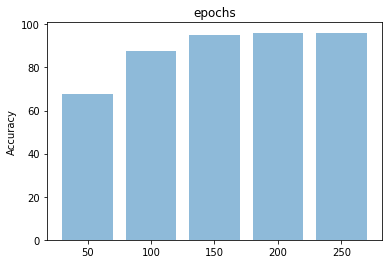

In [104]:
 #Test Epochs
breast_cancer_epoch_results = annHyperParamTest(epoch_test_values, 
                         datasets['breast_cancer']['train'], 
                         datasets['breast_cancer']['test'],
                         datasets['breast_cancer']['inputnodes'],
                         datasets['breast_cancer']['hiddennodes'],
                         datasets['breast_cancer']['outputnodes'],
                         'epochs')

In [105]:
breast_cancer_epoch_results

[67.6056338028169,
 87.67605633802818,
 95.07042253521126,
 95.77464788732394,
 96.12676056338029]

Epoch value of 250 gave greast accuracy, graph shows trend of higher accuracy with more epochs 

#### Learning Rate

##### Test Values

In [106]:
#Test Values
lr_test_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

##### Wine Dataset 

Training epoch#:  0
errors (SSE):  [1725.51895518]
Training epoch#:  1
errors (SSE):  [1611.62697576]
Training epoch#:  2
errors (SSE):  [1608.95060909]
Training epoch#:  3
errors (SSE):  [1608.05960708]
Training epoch#:  4
errors (SSE):  [1607.63843763]
Training epoch#:  5
errors (SSE):  [1607.40261967]
Training epoch#:  6
errors (SSE):  [1607.25582098]
Training epoch#:  7
errors (SSE):  [1607.15700381]
Training epoch#:  8
errors (SSE):  [1607.08604816]
Training epoch#:  9
errors (SSE):  [1607.03209663]
Training epoch#:  0
errors (SSE):  [1684.48720361]
Training epoch#:  1
errors (SSE):  [1618.32519545]
Training epoch#:  2
errors (SSE):  [1617.38702055]
Training epoch#:  3
errors (SSE):  [1617.09564198]
Training epoch#:  4
errors (SSE):  [1616.96201898]
Training epoch#:  5
errors (SSE):  [1616.88245666]
Training epoch#:  6
errors (SSE):  [1616.82360788]
Training epoch#:  7
errors (SSE):  [1616.77218791]
Training epoch#:  8
errors (SSE):  [1616.72205387]
Training epoch#:  9
errors (SSE

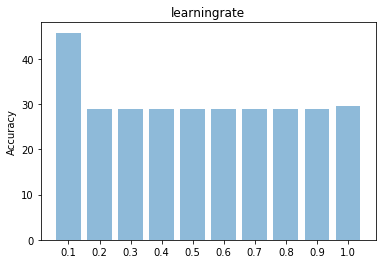

In [107]:
#Test Learning Rates
wine_lr_results = annHyperParamTest(lr_test_values,  
                         datasets['wine']['train'], 
                         datasets['wine']['test'],
                         datasets['wine']['inputnodes'],
                         datasets['wine']['hiddennodes'],
                         datasets['wine']['outputnodes'],
                         'learningrate')

In [108]:
wine_lr_results

[45.73295222539812,
 28.868926092282564,
 28.868926092282564,
 28.868926092282564,
 28.868926092282564,
 28.868926092282564,
 28.868926092282564,
 28.868926092282564,
 28.868926092282564,
 29.522253981216824]

Learning rate of 0.1 gave greatest accuracy, values for 0.2-0.9 were all identical

##### Breast Cancer Dataset 

Training epoch#:  0
errors (SSE):  [129.57222586]
Training epoch#:  1
errors (SSE):  [128.36737961]
Training epoch#:  2
errors (SSE):  [128.29345195]
Training epoch#:  3
errors (SSE):  [128.21247456]
Training epoch#:  4
errors (SSE):  [128.13059434]
Training epoch#:  5
errors (SSE):  [128.04762809]
Training epoch#:  6
errors (SSE):  [127.96336883]
Training epoch#:  7
errors (SSE):  [127.87760749]
Training epoch#:  8
errors (SSE):  [127.79013257]
Training epoch#:  9
errors (SSE):  [127.70072969]
Training epoch#:  0
errors (SSE):  [129.82687896]
Training epoch#:  1
errors (SSE):  [129.55720881]
Training epoch#:  2
errors (SSE):  [129.38862684]
Training epoch#:  3
errors (SSE):  [129.21550644]
Training epoch#:  4
errors (SSE):  [129.03613849]
Training epoch#:  5
errors (SSE):  [128.84876561]
Training epoch#:  6
errors (SSE):  [128.65157193]
Training epoch#:  7
errors (SSE):  [128.44266905]
Training epoch#:  8
errors (SSE):  [128.2200826]
Training epoch#:  9
errors (SSE):  [127.98173947]
T

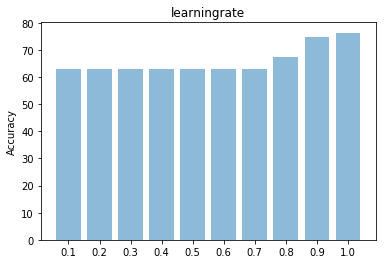

In [109]:
#Test Learning Rates
breast_cancer_lr_results = annHyperParamTest(lr_test_values,
                         datasets['breast_cancer']['train'], 
                         datasets['breast_cancer']['test'],
                         datasets['breast_cancer']['inputnodes'],
                         datasets['breast_cancer']['hiddennodes'],
                         datasets['breast_cancer']['outputnodes'],
                         'learningrate')

In [110]:
breast_cancer_lr_results

[63.02816901408451,
 63.02816901408451,
 63.02816901408451,
 63.02816901408451,
 63.02816901408451,
 63.02816901408451,
 63.02816901408451,
 67.6056338028169,
 75.0,
 76.40845070422534]

Learning rate of 1.0 gave greatest accuracy 

#### Batch Size

##### Test Values

In [111]:
#Test Values
batch_size_values = [1, 51, 101, 151, 201, 251]

##### Wine Dataset 

Training epoch#:  0
errors (SSE):  [1751.89867503]
Training epoch#:  1
errors (SSE):  [1611.43626193]
Training epoch#:  2
errors (SSE):  [1608.68697094]
Training epoch#:  3
errors (SSE):  [1607.75057552]
Training epoch#:  4
errors (SSE):  [1607.28851387]
Training epoch#:  5
errors (SSE):  [1607.01226942]
Training epoch#:  6
errors (SSE):  [1606.8242117]
Training epoch#:  7
errors (SSE):  [1606.68268509]
Training epoch#:  8
errors (SSE):  [1606.56717438]
Training epoch#:  9
errors (SSE):  [1606.46651175]
Training epoch#:  0
errors (SSE):  [3651.5713673]
Training epoch#:  1
errors (SSE):  [2343.20463446]
Training epoch#:  2
errors (SSE):  [2005.08018215]
Training epoch#:  3
errors (SSE):  [1868.02040472]
Training epoch#:  4
errors (SSE):  [1795.8247167]
Training epoch#:  5
errors (SSE):  [1751.90689281]
Training epoch#:  6
errors (SSE):  [1722.65236671]
Training epoch#:  7
errors (SSE):  [1701.90654635]
Training epoch#:  8
errors (SSE):  [1686.5048096]
Training epoch#:  9
errors (SSE):  

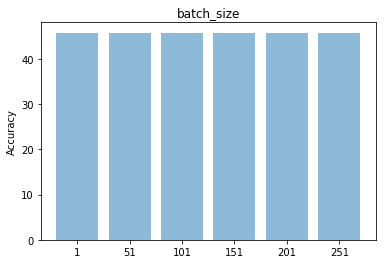

In [112]:
#Test Batch Sizes
wine_bs_results = annHyperParamTest(batch_size_values,
                         datasets['wine']['train'], 
                         datasets['wine']['test'],
                         datasets['wine']['inputnodes'],
                         datasets['wine']['hiddennodes'],
                         datasets['wine']['outputnodes'],
                         'batch_size')

In [113]:
wine_bs_results

[45.73295222539812,
 45.73295222539812,
 45.73295222539812,
 45.73295222539812,
 45.73295222539812,
 45.73295222539812]

Altering Batch Size had no effect on accuracy for these test values

##### Breast Cancer Dataset

Training epoch#:  0
errors (SSE):  [139.72767724]
Training epoch#:  1
errors (SSE):  [128.54002466]
Training epoch#:  2
errors (SSE):  [128.45971665]
Training epoch#:  3
errors (SSE):  [128.38544296]
Training epoch#:  4
errors (SSE):  [128.31068959]
Training epoch#:  5
errors (SSE):  [128.2352443]
Training epoch#:  6
errors (SSE):  [128.15891542]
Training epoch#:  7
errors (SSE):  [128.08150995]
Training epoch#:  8
errors (SSE):  [128.00283295]
Training epoch#:  9
errors (SSE):  [127.92268715]
Training epoch#:  0
errors (SSE):  [194.68927319]
Training epoch#:  1
errors (SSE):  [188.3037626]
Training epoch#:  2
errors (SSE):  [182.08001949]
Training epoch#:  3
errors (SSE):  [176.23756049]
Training epoch#:  4
errors (SSE):  [170.9474755]
Training epoch#:  5
errors (SSE):  [166.30515843]
Training epoch#:  6
errors (SSE):  [162.32708973]
Training epoch#:  7
errors (SSE):  [158.96777972]
Training epoch#:  8
errors (SSE):  [156.14517634]
Training epoch#:  9
errors (SSE):  [153.76389806]
Tra

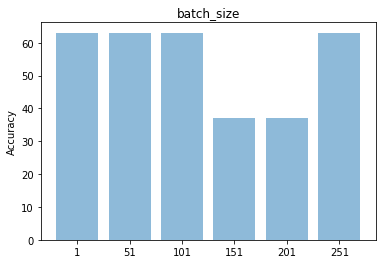

In [114]:
#Test Batch Sizes
breast_cancer_bs_results = annHyperParamTest(batch_size_values,
                         datasets['breast_cancer']['train'], 
                         datasets['breast_cancer']['test'],
                         datasets['breast_cancer']['inputnodes'],
                         datasets['breast_cancer']['hiddennodes'],
                         datasets['breast_cancer']['outputnodes'],
                         'batch_size')

In [115]:
breast_cancer_bs_results

[63.02816901408451,
 63.02816901408451,
 63.02816901408451,
 36.971830985915496,
 36.971830985915496,
 63.02816901408451]

Altering Batch Size had little effect on accuracy however values of 151 and 201 caused a dip in accuracy 